In [1]:
import pandas as pd
import numpy as np
import matplotlib
import torch
from glob import glob
import os
import json
from ecog_speech import datasets, feature_processing, experiments, utils
from tqdm.auto import tqdm

%matplotlib inline

/home/morgan/.conda/envs/venv/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


Load result JSON files into a list of objects

In [2]:
# Link a results dir in the project root
base_path = "../results/"

result_files = glob(os.path.join(base_path, '*.json'))

json_result_data = [json.load(open(f)) for f in tqdm(result_files)]

Parse into dataframe

In [3]:
results_df = pd.DataFrame(json_result_data).sort_values('f1', ascending=False)

results_df.columns

Index(['name', 'datetime', 'uid', 'batch_losses', 'num_trainable_params',
       'num_params', 'f1', 'accuracy', 'precision', 'recall', 'model_name',
       'dataset', 'learning_rate', 'dense_width', 'sn_n_bands',
       'sn_kernel_size', 'sn_padding', 'n_cnn_filters', 'dropout',
       'dropout_2d', 'batchnorm', 'roll_channels', 'power_q', 'n_epochs',
       'batch_size', 'device', 'save_model_path', 'tag', 'result_dir', 'path'],
      dtype='object')

In [4]:
results_df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_trainable_params,28.0,9563.928571,6.837153e+03,3163.000000,3361.000000,7606.000000,18019.000000,22123.000000
num_params,28.0,9563.928571,6.837153e+03,3163.000000,3361.000000,7606.000000,18019.000000,22123.000000
f1,28.0,0.920037,1.559990e-02,0.849631,0.916124,0.922422,0.926204,0.939230
accuracy,28.0,0.922693,1.539310e-02,0.851290,0.920138,0.925478,0.928598,0.940217
precision,28.0,0.953146,2.111599e-02,0.859213,0.952496,0.956974,0.962986,0.972029
recall,28.0,0.889504,1.994756e-02,0.840261,0.881587,0.888275,0.900290,0.931681
learning_rate,28.0,0.001000,6.624585e-19,0.001000,0.001000,0.001000,0.001000,0.001000
sn_n_bands,28.0,2.892857,1.423071e+00,1.000000,2.000000,3.000000,4.000000,5.000000
sn_kernel_size,28.0,31.000000,0.000000e+00,31.000000,31.000000,31.000000,31.000000,31.000000
sn_padding,28.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000


Config params are those parameters we want to split by if experiments were run with different values
- Use pandas to detect which config parameters were actually changed from the provided superset

In [5]:
perf_col = 'f1'

config_params = ['model_name', 'dataset', 'dense_width', 'sn_n_bands', 'sn_kernel_size', 'sn_padding',
     'n_cnn_filters', 'dropout', 'dropout_2d', 'batchnorm', 'roll_channels', 'power_q', 'n_epochs']

In [6]:
nun_config_params = results_df[config_params].nunique()

config_cols = nun_config_params[nun_config_params > 1].index.tolist()

print(f"Changing Params: {', '.join(config_cols)}")

Changing Params: sn_n_bands, n_cnn_filters, dropout


***

Inspect and viz

In [9]:
grp = results_df.groupby(config_cols)[perf_col]
res_perf = grp.mean()
res_n = grp.size()

In [10]:
res_perf_df = res_perf.reset_index()

In [11]:
res_perf_df

,sn_n_bands,n_cnn_filters,dropout,f1
0,1,8,0.00,0.924488
1,1,8,0.25,0.907011
2,1,16,0.00,0.925289
3,1,16,0.25,0.939230
4,1,32,0.00,0.922222
5,1,32,0.25,0.937337
6,2,8,0.00,0.922622
7,2,8,0.25,0.920952
8,2,16,0.00,0.926361
9,2,16,0.25,0.929777


<AxesSubplot:xlabel='sn_n_bands', ylabel='n_cnn_filters-dropout'>

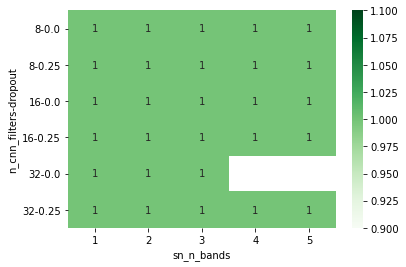

In [12]:
import seaborn as sns
sns.heatmap(res_n.unstack('sn_n_bands'), annot=True, cmap='Greens')

In [13]:
from IPython.display import display
def hplot(*args, **kwargs):
    #print(args)
    x = kwargs.pop('data')
    plt_df = x.groupby(list(args[:-1])).mean().reset_index().pivot(*args)
    #display(plt_df)
    ax = sns.heatmap(plt_df.T, 
                     annot=True, **kwargs)
    return ax

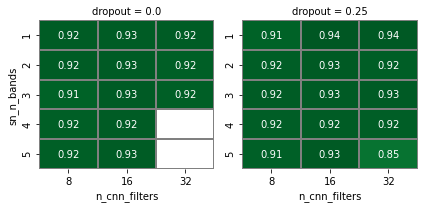

In [15]:
g = sns.FacetGrid(res_perf_df, #row="roll_channels", 
                  col="dropout",
                  # Sharing axis doesn't seem to work so well with sparse results - axes names and ticks get weird
                  sharex=False, sharey=False)
g.map_dataframe(hplot,'n_cnn_filters', 'sn_n_bands', 'f1',
                cmap='Greens', vmax=1., vmin=0., cbar=False, linewidths=1, linecolor='grey')